# Telling frogs from trucks: a binary classification example

## The CIFAR-10 dataset

Let's do it: binary classification. For this, we will use the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) image dataset. Though, we will restrict ourselves to two out of the ten classes available in the original dataset: frogs and trucks.

CIFAR-10 is already more challenging than the boston dataset in terms of dimensionality of the input data (3072 features per example vs. 13) and contains much more examples (50000 examples in the original training set). The binary classification task is simpler though than real value estimation.

Following code loads the CIFAR-10 dataset. If you are not working on jupyter.uvt.nl, you can replace the code of the `load_data()` function by this one line:
```
from keras.datasets.cifar10 import load_data
```

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.datasets.cifar import load_batch
from keras.utils.data_utils import get_file
from keras import backend as K
import numpy as np
import os

from keras.datasets import cifar10
from keras.datasets.cifar10 import load_data

In [3]:
# Remove some unwanted warnings
import logging
logging.getLogger('tensorflow').disabled = True 

from keras import backend as K

# Some memory clean-up
K.clear_session()

(x_train, y_train), (x_test, y_test) = load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


We will now filter the data to keep only half of the examples of the two categories 'frog' and 'truck' (only half to speed up computations). We will also reshape the input data corresponding to each image (32x32 RGB values) into a single vector of dimension 3072 (i.e. 32x32x3).

In [4]:
# Keeping a half of the examples of frogs (y=6) and trucks (y=9) only
sel_train = np.concatenate(((y_train == 6).nonzero()[0][:2500], (y_train == 9).nonzero()[0][:2500]))
x_train = x_train[sel_train, ...]
y_train = y_train[sel_train]
sel_test = np.logical_or(y_test == 6, y_test == 9).nonzero()[0]
x_test = x_test[sel_test, ...]
y_test = y_test[sel_test]
# Reshaping
x_train = x_train.reshape((x_train.shape[0], 3072))
x_test = x_test.reshape((x_test.shape[0], 3072))

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Converting label to a boolean value: '0' for frogs, '1' for trucks
y_train[y_train == 6] = 0
y_train[y_train == 9] = 1
y_test[y_test == 6] = 0
y_test[y_test == 9] = 1

x_train shape: (5000, 3072)
5000 train samples
2000 test samples


To get a feeling of the dataset, let's visualize a few examples.

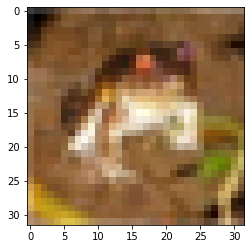

frog


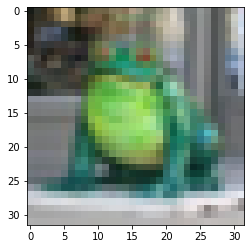

frog


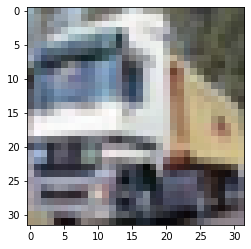

truck


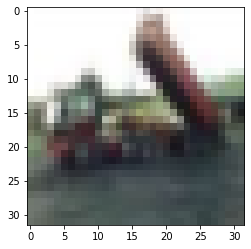

truck


In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

for idx in [0, 1, 2500, 2501]:
    plt.imshow(x_train[idx].reshape((32, 32, 3)), interpolation='nearest')
    plt.show()
    label = 'frog' if y_train[idx] == 0 else 'truck'
    print(label)

Finally, we need to create a validation set. CIFAR-10 is big enough that we can reserve a part of the training set for validation. Here, we will simply take the last 5<sup>th</sup> of the data.

In [6]:
sel_train = np.concatenate(((y_train == 0).nonzero()[0][:2000], (y_train == 1).nonzero()[0][:2000]))
sel_valid = np.concatenate(((y_train == 0).nonzero()[0][2000:], (y_train == 1).nonzero()[0][2000:]))
x_train_whole = x_train
y_train_whole = y_train
x_train = x_train_whole[sel_train, ...]
y_train = y_train_whole[sel_train]
x_valid = x_train_whole[sel_valid, ...]
y_valid = y_train_whole[sel_valid]

print(x_train.shape[0], 'train samples')
print(x_valid.shape[0], 'validation samples')

4000 train samples
1000 validation samples


In [21]:
# We standardize because why not

# Computing mean and standard deviation of the training data
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)

# Standardizing training, validation and test data
x_train = (x_train - mean) / std
x_valid = (x_valid - mean) / std

Reusing what you have seen during the 1<sup>st</sup> lecture and in the previous exercises, try to build and train a neural network for binary classification on the dataset we have just created. Keep the same number of layers and units we have used before as well as the ReLU activation function for the hidden layers. Use a batch size of 32 and 150 epochs for training.

## Building the Neural Network

In [24]:
from keras import models
from keras import layers

def build_model():
    
    model = models.Sequential()
    # Layer 1
    model.add(layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)))
    # Layer 2
    model.add(layers.Dense(64, activation='relu'))
    # Output Layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Model Compilation
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

## Arquitecture of the Network

In [8]:
import logging
logging.getLogger('tensorflow').disabled = True 

model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                196672    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 200,897
Trainable params: 200,897
Non-trainable params: 0
_________________________________________________________________


In [9]:
for i, layer in enumerate(model.layers):
    weights = layer.get_weights() # list of numpy arrays
    print("Layer ", str(i))
    print("First set of parameters, size:", len(weights[0]), "x", len(weights[0][0]), "- first value:", weights[0][0][0])
    print("Second set of parameters, size:", "1 x", len(weights[1]), "- first value:", weights[1][0])

Layer  0
First set of parameters, size: 3072 x 64 - first value: -0.031487077
Second set of parameters, size: 1 x 64 - first value: 0.0
Layer  1
First set of parameters, size: 64 x 64 - first value: -0.14291796
Second set of parameters, size: 1 x 64 - first value: 0.0
Layer  2
First set of parameters, size: 64 x 1 - first value: 0.09661609
Second set of parameters, size: 1 x 1 - first value: 0.0


## Training

In [25]:
# Build the Keras model (already compiled)
model2 = build_model()
# Train the model (in silent mode -> verbose=0)
print('Training...')
history = model2.fit(x_train, y_train,
                    validation_data=(x_valid, y_valid),
                    epochs=150, batch_size=32, verbose=0)
print('Training done.')

Training...
Training done.


## Evaluation

In [19]:
# Prestep for plotting
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

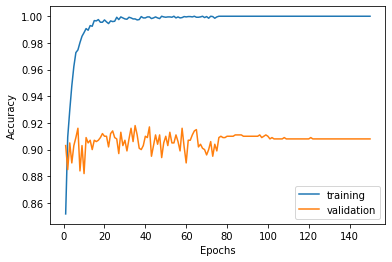

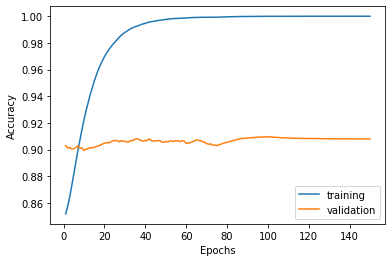

In [26]:
acc_history = history.history['accuracy']
val_acc_history = history.history['val_accuracy']

plt.plot(range(1, len(acc_history) + 1), acc_history)
plt.plot(range(1, len(val_acc_history) + 1), val_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.show()

smooth_acc_history = smooth_curve(acc_history)
val_smooth_acc_history = smooth_curve(val_acc_history)

plt.plot(range(1, len(smooth_acc_history) + 1), smooth_acc_history)
plt.plot(range(1, len(val_smooth_acc_history) + 1), val_smooth_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.show()

## Final Model
As we see, accuracy stabilises around 125 epochs with this architecture.

In [27]:
# Training the final model and the whole training set
# Computing mean and standard deviation of the whole training data
mean = x_train_whole.mean(axis=0)
std = x_train_whole.std(axis=0)

# Standardizing training and test data
x_train_whole = (x_train_whole - mean) / std
x_test = (x_test - mean) / std

# Get a fresh, compiled model.
modelf = build_model()
# Train it on the entirety of the data.
modelf.fit(x_train_whole, y_train_whole,
          epochs=125, batch_size=32, verbose=0)
test_loss_score, test_acc_score = modelf.evaluate(x_test, y_test)
print("Test accuracy:", test_acc_score)

2000/2000 [==============================] - 0s 38us/step
Test accuracy: 0.9150000214576721


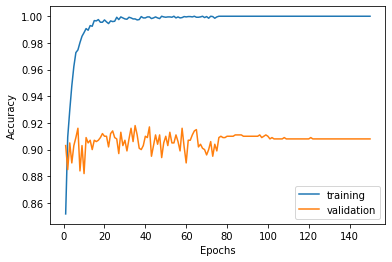

In [28]:
acc_history = history.history['accuracy']
val_acc_history = history.history['val_accuracy']

plt.plot(range(1, len(acc_history) + 1), acc_history)
plt.plot(range(1, len(val_acc_history) + 1), val_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.show()

<div class="alert alert-block alert-info">
    
**Final Test Accuracy: 91,5%** 
- Features:
    - Neural Network: **Multilayer Perceptron** (3 layers).
    - Hidden "relu activation".
    - Output "sigmoid activation".
    - Batch Size = 32
    - Epochs = 125